In [18]:
import pandas as pd

# Load the dataset
df = pd.read_csv("data_censored.csv")

# Create a 'trial_period' column to mimic the expansion process
df['trial_period'] = df.groupby('id').cumcount()

# Display the first few rows
df.head()




,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,trial_period
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1,0
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0,1
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0,2
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0,3
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0,4


In [19]:
# Check basic info
df.info()

# Summary statistics
df.describe()

# Check for missing values
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            725 non-null    int64  
 1   period        725 non-null    int64  
 2   treatment     725 non-null    int64  
 3   x1            725 non-null    int64  
 4   x2            725 non-null    float64
 5   x3            725 non-null    int64  
 6   x4            725 non-null    float64
 7   age           725 non-null    int64  
 8   age_s         725 non-null    float64
 9   outcome       725 non-null    int64  
 10  censored      725 non-null    int64  
 11  eligible      725 non-null    int64  
 12  trial_period  725 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 73.8 KB


id              0
period          0
treatment       0
x1              0
x2              0
x3              0
x4              0
age             0
age_s           0
outcome         0
censored        0
eligible        0
trial_period    0
dtype: int64

In [20]:
import statsmodels.api as sm
import numpy as np

# Define independent variables for censoring model
X_censor = df[['x2', 'x1']]
X_censor = sm.add_constant(X_censor)

# Define dependent variable (censored indicator)
y_censor = df['censored']

# Fit logistic regression for IPCW
ipcw_model = sm.Logit(y_censor, X_censor).fit()
df['censor_prob'] = ipcw_model.predict(X_censor)

# Compute IPCW weights
df['ipcw_weight'] = 1 / (1 - df['censor_prob'])

# Prevent extreme values (Winsorization)
df['ipcw_weight'] = np.clip(df['ipcw_weight'], 0, df['ipcw_weight'].quantile(0.99))

# Debug: Check if `ipcw_weight` is correctly assigned
print(df[['censored', 'censor_prob', 'ipcw_weight']].head())



Optimization terminated successfully.
         Current function value: 0.267425
         Iterations 7
   censored  censor_prob  ipcw_weight
0         0     0.085615     1.093631
1         0     0.051819     1.054651
2         0     0.080719     1.087807
3         0     0.099556     1.110563
4         0     0.056993     1.060438


In [21]:
from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
features = df[['age', 'x1', 'x2', 'x3', 'x4']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)



In [22]:
from sklearn.cluster import KMeans

# Apply K-Means clustering (choose 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Check cluster distribution
df['cluster'].value_counts()


cluster
0    294
2    216
1    215
Name: count, dtype: int64

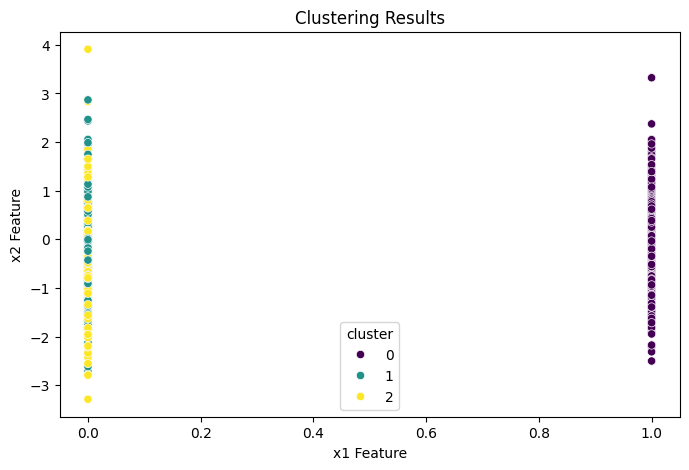

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['x1'], y=df['x2'], hue=df['cluster'], palette='viridis')
plt.xlabel("x1 Feature")
plt.ylabel("x2 Feature")
plt.title("Clustering Results")
plt.show()


In [24]:
# Ensure 'trial_period' exists in df
if 'trial_period' not in df.columns:
    df['trial_period'] = df.groupby('id').cumcount()



In [25]:
import statsmodels.api as sm

for cluster in df['cluster'].unique():
    subset = df[df['cluster'] == cluster].copy()
    
    print(f"Running TTE for Cluster {cluster}")
    
    # Debugging step: Print available columns in subset
    print("Subset columns:", subset.columns.tolist())

    # Ensure 'ipcw_weight' exists in subset
    if 'ipcw_weight' not in subset.columns:
        raise KeyError("Column 'ipcw_weight' is missing from subset DataFrame.")

    # Define independent variables
    X = subset[['treatment', 'x2', 'trial_period']]
    X = sm.add_constant(X)

    # Define dependent variable (outcome)
    y = subset['outcome']

    # Fit model with IPCW weights
    weights = subset['ipcw_weight']
    model = sm.WLS(y, X, weights=weights).fit()

    print(model.summary())


Running TTE for Cluster 0
Subset columns: ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible', 'trial_period', 'censor_prob', 'ipcw_weight', 'cluster']
                            WLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.019
Model:                            WLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.901
Date:                Sun, 09 Mar 2025   Prob (F-statistic):              0.129
Time:                        23:51:03   Log-Likelihood:                 215.29
No. Observations:                 294   AIC:                            -422.6
Df Residuals:                     290   BIC:                            -407.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
      

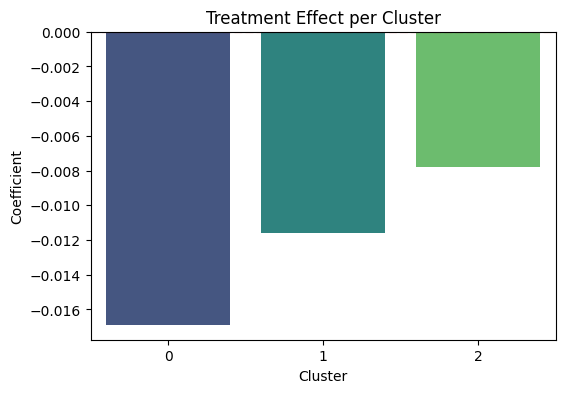

In [27]:
treatment_effects = [-0.0169, -0.0116, -0.0078]  # Extracted from model summaries
cluster_labels = ['0', '1', '2']

df_results = pd.DataFrame({'Cluster': cluster_labels, 'Treatment Effect': treatment_effects})

plt.figure(figsize=(6, 4))
sns.barplot(x="Cluster", y="Treatment Effect", data=df_results, hue="Cluster", palette="viridis", legend=False)

plt.title("Treatment Effect per Cluster")
plt.ylabel("Coefficient")
plt.xlabel("Cluster")
plt.axhline(0, color="red", linestyle="dashed")
plt.show()

